# Visualizing the auto-correlation of an image.

In this notebook, we will use calculate the auto-correlations of images and visualize these as a function of radial distance and angle. We will do so for a number of different architectures to see how they impact these properties.

In [1]:
# reload imports so if you change stuff in models/cppn.py it'll update the notebook periodically to see it.
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/Users/Heysoos/Documents/Pycharm Projects/Dissertation/01_CPPN')
from models.cppn import CPPN, Sampler, multiscale_targets_apply

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns
import imageio
from PIL import Image
from datetime import datetime
from tqdm import tqdm
import scipy.signal

plt.style.use('default') # if it's using the wrong style for some reason

from IPython.display import display, clear_output
import time

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def are_triangles_equal(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Matrix must be square.")

    # Extract the upper and lower triangles of the matrix
    upper_triangle = np.triu(matrix, k=1)
    lower_triangle = np.tril(matrix, k=-1)

    # Transpose the lower triangle for comparison
    lower_triangle_transposed = lower_triangle.T
    
    triangle_diff = np.abs(upper_triangle - lower_triangle).sum()

    # Check if the upper and lower triangles are equal
    return np.array_equal(upper_triangle, lower_triangle_transposed), triangle_diff

def img_autocorr(img):
    I = np.ones(np.shape(img))
    mass = np.round(scipy.signal.fftconvolve(I, I))
    corr = fft_autocorr_norm(img, mass, I, clean=True)
    return corr

def fft_autocorr_norm(img, mass, I, clean=True):
    ###
    # calculate the auto-correlation of 'img' normalizing with respect to local means and variances
    # I: np.ones(np.shape(img))
    # mass: convolve(I, I)
    # these matrices are not included in this function to save computation
    ###
    local_mean = scipy.signal.fftconvolve(img, I) / mass
    sum_img_sqr = scipy.signal.fftconvolve(img ** 2, I)

    if clean:
        local_mean[local_mean < 0] = 0
        sum_img_sqr[sum_img_sqr < 0] = 0

    local_var = (sum_img_sqr - mass * local_mean ** 2) / mass

    if clean:
        local_var[local_var < 1e-8] = 1e-8
        local_var[np.isinf(local_var)] = np.nan


    G = scipy.signal.fftconvolve(img, img[::-1, ::-1])
    means_terms = mass * -1 * (local_mean * local_mean[::-1, ::-1])
    auto_corr = (G + means_terms) / (mass * np.sqrt(local_var * local_var[::-1, ::-1]))

    ## return upper triangle
    # shape = np.shape(auto_corr)
    # tri_eq, tri_diff = are_triangles_equal(auto_corr)
    # print(f'Triangles equal: {tri_eq}')
    # print(f'Triangles equal: {tri_diff:.4f}')
    # iu = np.triu_indices(n=shape[0], m=shape[1])
    # return auto_corr[iu]
    
    return auto_corr

In [4]:
def dist_mat(shape):
    center = np.array(shape) // 2
    y, x = np.indices(shape)
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    r = r.astype('int')
    
    return r

def theta_mat(shape):
    center = np.array(shape) // 2
    y, x = np.indices(shape)
    theta = np.arctan2(y - center[0], x - center[1])
    
    return theta

def dist_vec(shape):
    n = shape[0]
    m = shape[1]
    iu = np.triu_indices(n=n, m=m, k=0)

    distu = np.sqrt((iu[0] - (n-1)/2)**2 + (iu[1] - (m-1)/2)**2)

    return distu

def theta_vec(shape):
    n = shape[0]
    m = shape[1]
    iu = np.triu_indices(n=n, m=m, k=0)


    thetau = np.arctan2((iu[0] - (n-1)/2), (iu[1] - (m-1)/2))

    return thetau

In [5]:
net_size = [64, 256, 256, 64, 32, 6, 6, 6]    
dim_z = 16
dim_c = 3

# Fourier Features settings
proj_dims = [128]
proj_scales = [2. for i in proj_dims]
projection_config = (proj_dims, proj_scales)


# Generate an Example Image

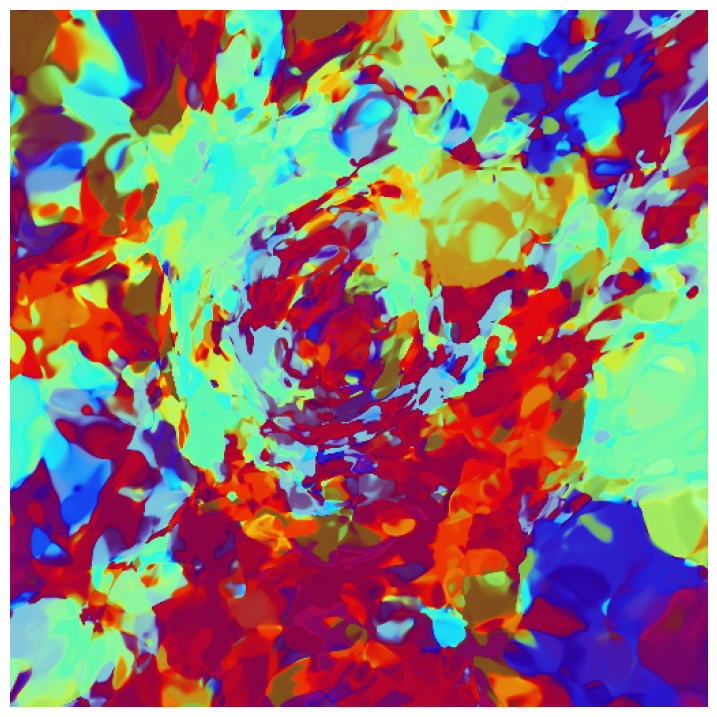

In [80]:
cppn = CPPN(net_size, dim_z, dim_c, projection_config=projection_config).cuda()
sampler = Sampler(cppn)
cppn.reinit(empty_cache=True)

gscale = 1
scale = 1.
xres = 512
yres = int(xres)
zscale = 1.
nscale = 0

z =  torch.randn(1, dim_z).cuda()
delta_v = torch.randn(1, dim_z).cuda() 
# delta_v = delta_v / torch.norm(delta_v)
z2 = z + 0.02*delta_v
coords = cppn._coordinates(scale*gscale,
                           xres, yres, z*zscale*gscale)

# coords[2] = coords[2] * 0.

x = sampler.generate_img(cppn, z*zscale, scale, xres, yres, coords=coords)
sampler.imshow((x * 255).astype(np.uint8))

There are some different ways to visualize/define the auto-correlation (AC) function of an image, here we show two ways, the auto-correlation as a function of radius, and as a function of its angle.

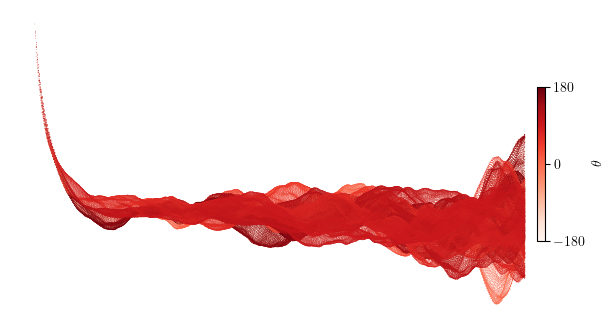

In [87]:
plt.figure(figsize=(8, 4))
cmap = 'Reds'

r = dist_mat((2*xres-1, 2*xres-1)).reshape(-1)
jitter = 0.2 * np.random.randn(*r.shape) # important to not have all the pixels align
shuffle_idx = np.arange(0, len(r)) # we shuffle the entries so that the colours don't get overwritten
# np.random.shuffle(shuffle_idx)
# r = r[shuffle_idx]

r = r + jitter
theta = theta_mat((2*xres-1, 2*xres-1)).reshape(-1) * 180/np.pi
theta = theta[shuffle_idx]
mask_boundary = xres # np.min([xres, yres])
mask = r < mask_boundary # mask values outside the boundaries where things usually get weird

y_plot = img_autocorr(x.mean(axis=-1)).reshape(-1)
y_plot = y_plot[shuffle_idx]
plt.scatter(r[mask], y_plot[mask], c=theta[mask], marker='.', s=1., alpha=1., cmap=cmap, edgecolors=None, linewidths=0)
plt.xlabel(r'$r$')
# Create a ScalarMappable with no transparency for the colorbar
norm = colors.Normalize(vmin=np.round(np.min(theta[mask])), vmax=np.round(np.max(theta[mask])))
scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
scalar_mappable.set_array(theta)

plt.axis('off')
plt.colorbar(scalar_mappable, orientation='vertical', label=r'$\theta$', shrink=0.5, pad=-0.02, ticks=[-180, 0, 180])
# plt.savefig('../figures/test.png')

Or we can plot is a function of theta.

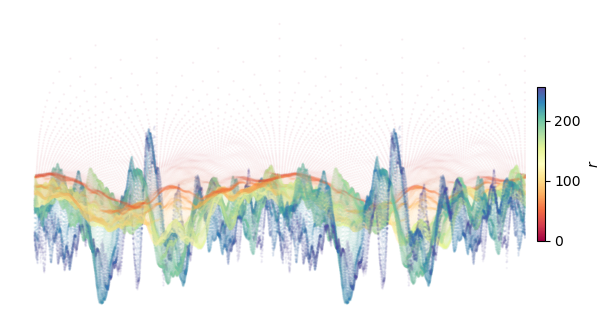

In [9]:
plt.figure(figsize=(8, 4))
plt.scatter(theta[mask], y_plot[mask], c=r[mask], s=0.5, alpha=0.05, cmap=cmap)
plt.xlabel(r'$\theta$')

# Create a ScalarMappable with no transparency for the colorbar
norm = colors.Normalize(vmin=np.round(np.min(r[mask])), vmax=np.round(np.max(r[mask])))
scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
scalar_mappable.set_array(theta)

plt.axis('off')
plt.colorbar(scalar_mappable, orientation='vertical', label=r'$r$', shrink=0.5, pad=-0.02)
plt.show()

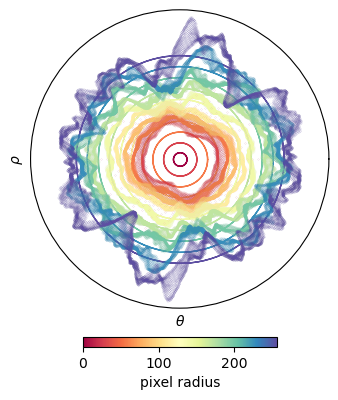

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw=dict(polar=True))
# theta = theta_mat((2*xres-1, 2*xres-1)).reshape(-1)

num_colors = 10
bin_edges = np.linspace(0, xres - xres//10, num_colors + 1)
polar_colors = plt.cm.Spectral(np.linspace(0, 1, num_colors))

for i in range(num_colors):
    mask_polar = np.logical_and(r > bin_edges[i], r <= bin_edges[i + 1])
    r_offset = 2*np.mean(r[mask_polar]/np.max(r))
    ax.plot(theta[mask_polar], (y_plot[mask_polar] + r_offset), '.', color=polar_colors[i], ms=0.1, alpha=1.);
    
    ax.fill_between(np.linspace(0, 2*np.pi, 100),
                     r_offset.mean() - 0.01 * r_offset.std(),
                     r_offset.mean() + 0.01 * r_offset.std(), color=polar_colors[i], alpha=1.);

# Create a ScalarMappable with no transparency for the colorbar
norm = colors.Normalize(vmin=np.round(np.min(r[mask])), vmax=np.round(np.max(r[mask])))
scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
scalar_mappable.set_array(theta)

plt.colorbar(scalar_mappable, orientation='horizontal', label=r'pixel radius', shrink=0.5, pad=0.075)


ax.set_xlabel(r'$\theta$');
ax.set_ylabel(r'$\rho$');
ax.set_yticks([]);
ax.set_xticks([]);

# Generate images

Make a loop that generates images with a number of different architectures.

In [82]:
net_sizes = [
    3 * [32],
    8 * [32] + [9, 3],
    3 * [512] + [9, 3],
    3 * ([512, 256, 4]),
    3 * [512, 256] + [2],
    [8, 256, 256, 64, 32, 6, 6, 6]
]

figure_imgs = []
for i_arch in tqdm(range(len(net_sizes))):
    cppn = CPPN(net_sizes[i_arch], dim_z, dim_c, projection_config=projection_config).cuda()
    arch_images = []
    with torch.no_grad():
        x = sampler.generate_img(cppn, z*zscale, scale, xres, yres, coords=coords)

    figure_imgs.append(x)

100%|██████████| 7/7 [00:00<00:00,  8.71it/s]


# Settings up the figures

In [83]:
# graphical properties
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': 10})
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 10
})


# cm = 1/2.54  # centimeters in inches

# size of full-width figures:
#fig = plt.figure(figsize=(18*cm, xx*cm))

# size of half-width figures:
#fig = plt.figure(figsize=(9*cm, 12.4*cm))

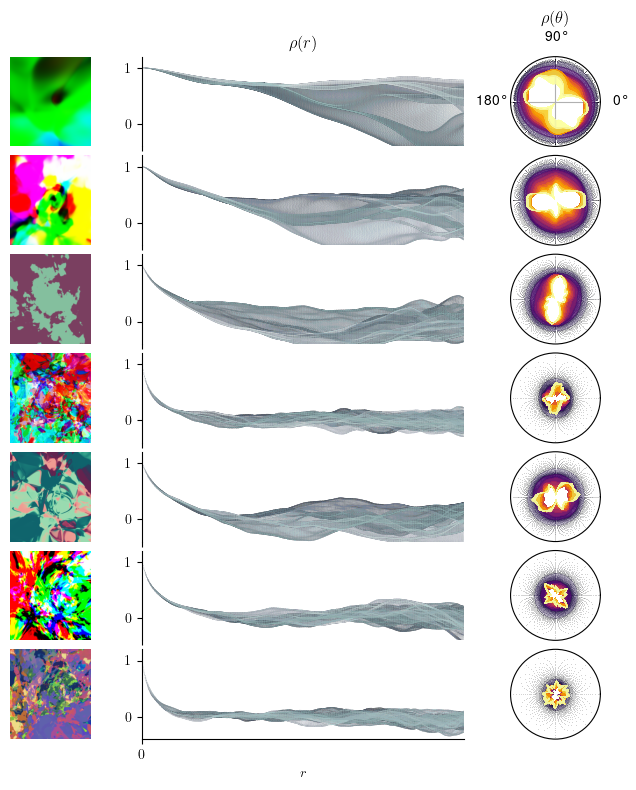

In [94]:
N = 3 # (img, AC(r), AC(theta))
M = len(net_sizes)

fig, axes = plt.subplots(nrows=M, ncols=N, figsize=(7, 8), sharex=True, gridspec_kw={'width_ratios': [1, 2, 1]})

cmap = 'bone'

# pre-calculate some stuff
r = dist_mat((2*xres-1, 2*xres-1))
theta = theta_mat((2*xres-1, 2*xres-1))
mask_boundary = xres - xres//10 # np.min([xres, yres])
mask = r < mask_boundary # mask values outside the boundaries where things usually get weird

# Loop through the grid and display images
for i in range(M): #rows
    
    # CPPN image
    #################################
    axes[i, 0].imshow(figure_imgs[i])
    #################################
    
    # AC(r)
    #################################
    theta *= 180/np.pi
    
    y_plot = img_autocorr(figure_imgs[i].mean(axis=-1))
    axes[i, 1].scatter(r[mask], y_plot[mask], c=theta[mask], marker='.', s=1., alpha=0.1, cmap=cmap, edgecolors=None, linewidths=0, rasterized=True)
    
    # xy lines    
    # axes[i, 1].plot([0.1 * np.max(r[mask]), 0.15 * np.max(r[mask])], [0, 0.],  'k')
    # axes[i, 1].plot([0.1 * np.max(r[mask]), 0.1 * np.max(r[mask])], [0, 0.15], 'k')
    
    # if i == 0:
    #     # colorbar
    #     norm = colors.Normalize(vmin=np.round(np.min(theta[mask])), vmax=np.round(np.max(theta[mask])))
    #     scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    #     scalar_mappable.set_array(theta)
    #     plt.colorbar(scalar_mappable, ax=axes[i, 1], orientation='vertical', label=r'$\theta$', shrink=0.5, pad=-0.02, ticks=[-180, 0, 180])
        
    axes[i, 1].set_ylim([-0.4, 1.2])
    #################################
    
    # AC(theta)
    #################################
    if axes[i, 2].name != 'polar':
        axes[i, 2].remove()  # Remove the current axes
        axes[i, 2] = fig.add_subplot(M, N, i * N + 3, projection='polar')  # Add a new polar subplot
    
    theta /= 180/np.pi

    num_colors = 10
    # polar_colors = plt.cm.Spectral(np.linspace(0, 1, num_colors))
    polar_colors = (plt.cm.inferno(np.linspace(0, 1, num_colors)))
    
    for j in range(num_colors):
        mask_polar = np.logical_and(r > bin_edges[j], r <= bin_edges[j + 1])
        r_offset = 0.5*np.mean(r[mask_polar]/np.max(r))
        # we clip the values here because sometimes it can explode and we can't always use ylim
        axes[i, 2].plot(theta[mask_polar], (np.clip(y_plot[mask_polar],a_min=-1, a_max=1.) + r_offset),
                        '.', color=polar_colors[j], ms=0.5, alpha=1., markeredgewidth=0, rasterized=True)        
        # axes[i, 2].fill_between(np.linspace(0, 2*np.pi, 100),
        #                  r_offset.mean() - 0.01 * r_offset.std(),
        #                  r_offset.mean() + 0.01 * r_offset.std(), color=polar_colors[j], alpha=1.);

    
    # if i == 0:
    #     # colorbar
    #     norm = colors.Normalize(vmin=np.round(np.min(r[mask])), vmax=np.round(np.max(r[mask])))
    #     scalar_mappable = cm.ScalarMappable(norm=norm, cmap='Spectral')
    #     scalar_mappable.set_array(theta)
    #     plt.colorbar(scalar_mappable, ax=axes[i, 2], orientation='horizontal', label=r'pixel radius', shrink=0.5, pad=0.075)
    
    
    # polar axis stuff
    axes[i, 2].set_yticks([])
    if i == 0:
        axes[i, 2].set_xticks([0,np.pi/2, np.pi, 3*np.pi/2], fontsize=10)
    else: 
        axes[i, 2].set_xticks([])

# image axis settings
for ax in axes[:, 0]:
    ax.axis('off')

# AC(r) axis settings
for ax in axes[:, 1]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([0])
    ax.set_xlim([0, mask_boundary])
axes[-1, 1].spines['bottom'].set_visible(True)

# labels and titles
axes[0, 1].set_title(r'$\rho(r)$')
axes[0, 2].set_title(r'$\rho(\theta)$')
axes[-1, 1].set_xlabel(r'$r$')
plt.tight_layout()

plt.subplots_adjust(wspace=0.05, hspace=0.1) 
plt.savefig('../figures/cppn_AC_new.pdf', bbox_inches='tight', dpi=900)

plt.show()